In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 180 (delta 80), reused 130 (delta 43), pack-reused 0
Receiving objects: 100% (180/180), 28.69 MiB | 28.50 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=15097 sha256=31a273105731529f9ec3aff594885c4d3733826b0fa51366ab748509406421cc
  Stored in directory: /tmp/pip-ephem-wheel-cache-is6df7fs/wheels/55/59/29/0fb1c63565215773

In [2]:
from dul_2021.utils.hw4_utils import *

In [3]:
!pip install torchdiffeq

In [4]:
from typing import Tuple, List, Optional
from tqdm.auto import trange

import numpy as np

import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.distributions import MultivariateNormal
from tqdm import tqdm

from torchdiffeq import odeint_adjoint as odeint

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Dataset 1


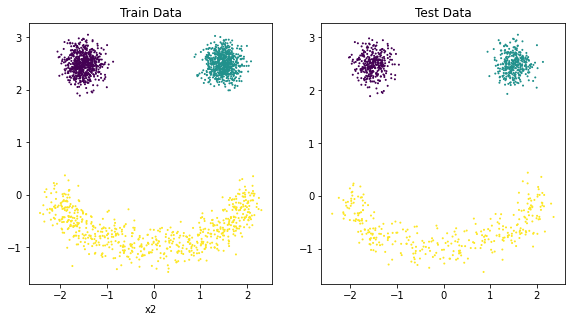

Dataset 2


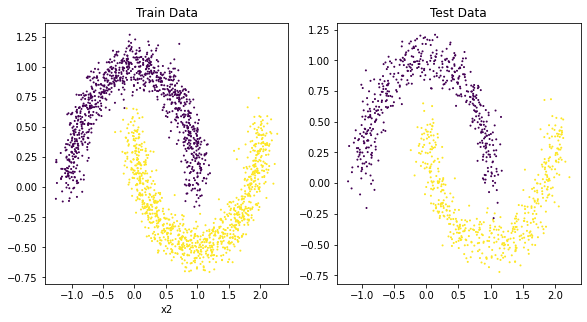

In [5]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

In [15]:
class CNF(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32, bias_size=3):
        super().__init__()

        self.input_dim = input_dim
        self.width = bias_size
        self.block_size = bias_size * input_dim

        self.model = self.model = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2 * self.block_size + bias_size)
        )

    @property
    def device(self):
        return next(iter(self.parameters())).device

    @property
    def base_dist(self):
        return MultivariateNormal(torch.zeros(2, device=self.device), torch.eye(2, device=self.device))

    def get_u_w_b(self, t):
        out = self.model(t.unsqueeze(0)).squeeze()

        u = out[: self.block_size].reshape(self.width, 1, self.input_dim)
        w = out[self.block_size: 2 * self.block_size].reshape(self.width, self.input_dim, 1)
        b = out[-self.width:].reshape(self.width, 1, 1)

        return [u, w, b]

    def get_dz_dt(self, t, z):
        u, w, b = self.get_u_w_b(t)
        z_r = z.unsqueeze(0).repeat(self.width, 1, 1)
        h = torch.tanh(z_r.matmul(w) + b)

        return h.matmul(u).mean(dim=0)

    def get_dlog_p_dt(self, f, z):
        batch_size = z.shape[0]
        m_trace = torch.zeros(batch_size, device=self.device)
        for i in range(self.input_dim):
            m_trace -= torch.autograd.grad(f[:, i].sum(), z, create_graph=True)[0][:, i]
        return m_trace.reshape(batch_size, 1)

    def forward(self, t, input):
        with torch.set_grad_enabled(True):
            z, _ = input
            z.requires_grad_(True)

            dz_dt = self.get_dz_dt(t, z)

            dlog_p_dt = self.get_dlog_p_dt(dz_dt, z)

            return dz_dt, dlog_p_dt

    def flow(self, z_1, t_0=0, t_1=10):
        dlog_p_dt_1 = torch.zeros((z_1.shape[0], 1)).float().to(self.device)
        z_t, m_log_det_t = odeint(
            self,
            (z_1, dlog_p_dt_1),
            torch.tensor([t_1, t_0]).to(self.device, torch.float32),
            atol=1e-5,
            rtol=1e-5,
            method='dopri5',
        )

        z_0, log_det = z_t[-1], -m_log_det_t[-1]

        return z_0, log_det

    def log_prob(self, batch, t_0=0, t_1=10):
        z, log_det = self.flow(batch, t_0, t_1)
        return self.base_dist.log_prob(z).reshape(-1, 1) + log_det

    def nll(self, batch, t_0=0, t_1=10):
        return -self.log_prob(batch, t_0, t_1).mean()

    @torch.no_grad()
    def get_probabilities(self, dataloader: DataLoader):
        probabilities = []
        for batch in dataloader:
            batch_probabilities = self.log_prob(batch.to(self.device)).exp()
            probabilities.append(batch_probabilities.cpu().numpy())
        return np.vstack(probabilities)

    @torch.no_grad()
    def get_latent_vectors(self, dataloader: DataLoader):
        latent_vectors = []
        for batch in dataloader:
            batch_latent_vectors = self.flow(batch.to(self.device))[0]
            latent_vectors.append(batch_latent_vectors.cpu().numpy())
        return np.vstack(latent_vectors)


class Trainer:
    def __init__(self, n_epochs, lr, grad_clip=None, device=DEVICE):
        self.n_epochs = n_epochs
        self.device = device
        self.lr = lr
        self.grad_clip = grad_clip

    def fit(self, model, train_loader, val_loader):
        train_loss = []
        test_loss = []

        optimizer = opt.Adam(model.parameters(), lr=self.lr)

        model.to(self.device)
        test_loss.append(self.evaluate(model, val_loader))
        for epoch in range(self.n_epochs):
            model.train()
            tqdm_steps = tqdm(train_loader, desc=f"Training")
            for batch in tqdm_steps:
                loss = self.train_step(model, batch)

                optimizer.zero_grad()
                loss.backward()
                if self.grad_clip:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), self.grad_clip)
                optimizer.step()

                train_loss.append(loss.cpu().item())
                tqdm_steps.set_postfix(train_loss=train_loss[-1])

            test_loss.append(self.evaluate(model, val_loader))

        return train_loss, test_loss

    def train_step(self, model, batch, deq=True):
        x = batch.to(self.device, dtype=torch.float32)

        if deq:
            x = torch.clip((x + torch.rand(batch.shape, device=self.device)) / 2.0, 0, 1)

        loss = model.nll(x)
        return loss

    @torch.no_grad()
    def evaluate(self, model, val_loader):
        losses = []
        model.eval()
        for batch in val_loader:
            loss = self.train_step(model, batch, False)
            losses.append(loss.item())

        return np.mean(losses)

In [18]:
def q1(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats in R^2
    test_data: An (n_test, 2) numpy array of floats in R^2
    dset_id: An identifying number of which dataset is given (1 or 2)

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
        Refer to the commented hint.
    - a numpy array of size (n_train, 2) of floats in [0,1]^2. This represents 
        mapping the train set data points through our flow to the latent space. 
    """
    batch_size = 128
    n_epochs = 100
    lr = 1e-3
    device = torch.device("cuda")
    grad_clip = 1

    # train_data = train_data.transpose(0, 3, 1, 2)
    # test_data = test_data.transpose(0, 3, 1, 2)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_data, batch_size=batch_size)

    model = CNF()

    trainer = Trainer(n_epochs=n_epochs, lr=lr, grad_clip=grad_clip, device=device)

    tr_loss, te_loss = trainer.fit(model, train_loader, val_loader)

    # heatmap
    dx, dy = 0.025, 0.025
    if dset_id == 1:  # face
        x_lim = (-4, 4)
        y_lim = (-4, 4)
    elif dset_id == 2:  # two moons
        x_lim = (-1.5, 2.5)
        y_lim = (-1, 1.5)
    
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)
    ]

    mesh_xs = np.stack([x, y], axis=2).reshape(-1, 2)
    mesh_xs_dataloader = DataLoader(
        torch.tensor(mesh_xs, dtype=torch.float32),
        batch_size=batch_size,
        shuffle=False
    )
    densities = model.get_probabilities(mesh_xs_dataloader)

    points_dataloader = DataLoader(
        torch.FloatTensor(train_data),
        batch_size=batch_size, 
        shuffle=False
    )
    latents = model.get_latent_vectors(points_dataloader)

    return tr_loss, te_loss, densities, latents

Training: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s, train_loss=-.898]


Final Test Loss: 12.1841


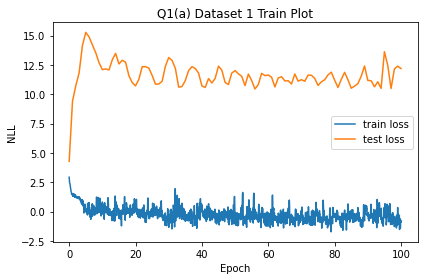

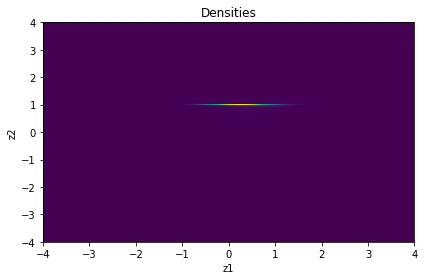

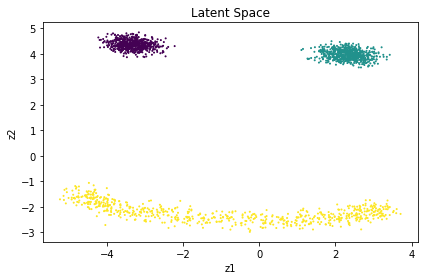

In [19]:
q1_save_results(1, 'a', q1)